<a href="https://colab.research.google.com/github/ItayG6454/Time-Series-Course/blob/main/timeseries_birth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [3]:
df = pd.read_excel('birth_data.xlsx')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
monthly_birth = df.copy()

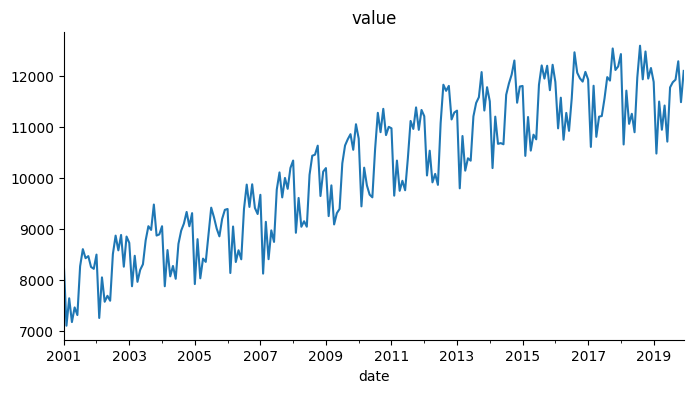

In [4]:
monthly_birth['value'].plot(kind='line', figsize=(8, 4), title='value')
plt.gca().spines[['top', 'right']].set_visible(False)

### Estimating seasonal effect using fourier analysis

In [62]:
def fit_model_and_calculate_aic(data, K):
    features = [f'sin_{k}' for k in range(1, K + 1)] + [f'cos_{k}' for k in range(1, K + 1)]
    X = data[features]
    y = data['value']

    # Add date from the index to X if needed for model fitting or just drop it if not used further
    # Example if 'date' is needed for some reason:
    # X['date'] = data.index

    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    aic = n * np.log(mse) + 2 * len(X.columns)

    return aic, model, predictions


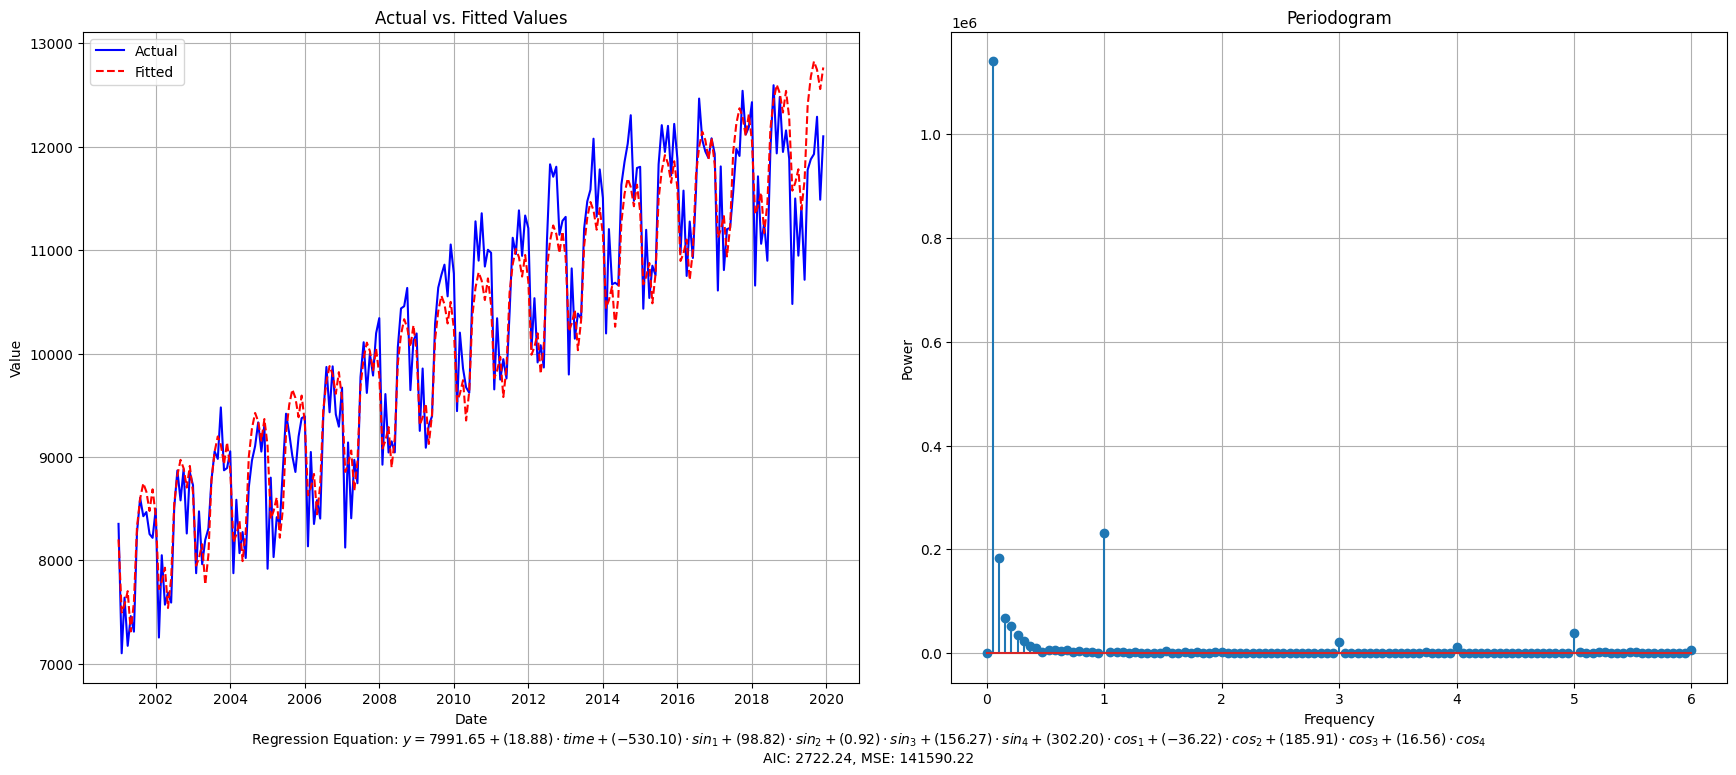

In [81]:
n = len(monthly_birth)
t = np.arange(1, n + 1)

# Adding Fourier terms and fitting the model
monthly_birth['time'] = t  # Linear trend term
K = 4  # Optimal number of harmonics
for k in range(1, K + 1):
    monthly_birth[f'sin_{k}'] = np.sin(2 * np.pi * k * t / 12)
    monthly_birth[f'cos_{k}'] = np.cos(2 * np.pi * k * t / 12)

features = ['time'] + [f'sin_{k}' for k in range(1, K + 1)] + [f'cos_{k}' for k in range(1, K + 1)]
X = monthly_birth[features]
y = monthly_birth['value']

model = LinearRegression().fit(X, y)
monthly_birth['fitted'] = model.predict(X)

# MSE and AIC calculations
mse = mean_squared_error(y, monthly_birth['fitted'])
aic = n * np.log(mse) + 2 * (K * 2 + 1)  # +1 for the intercept

# Calculate periodogram
frequencies, power = periodogram(monthly_birth['value'],fs=12, scaling='spectrum')

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot actual vs. fitted
axs[0].plot(data.index, monthly_birth['value'], label='Actual', color='blue')
axs[0].plot(data.index, monthly_birth['fitted'], label='Fitted', linestyle='--', color='red')
axs[0].set_title('Actual vs. Fitted Values')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# Plot periodogram
axs[1].stem(frequencies, power)
axs[1].set_title('Periodogram')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power')
axs[1].grid(True)

# Regression equation and metrics
coefficients = ['time'] + [f'sin_{k}' for k in range(1, K + 1)] + [f'cos_{k}' for k in range(1, K + 1)]
regression_eq = "$y = {:.2f}".format(model.intercept_)
for coef, name in zip(model.coef_, coefficients):
    regression_eq += " + ({:.2f}) \cdot {}".format(coef, name)
regression_eq += "$"

metrics_info = f'AIC: {aic:.2f}, MSE: {mse:.2f}'

plt.figtext(0.5, 0.01, f'Regression Equation: {regression_eq}\n{metrics_info}', ha='center', fontsize=10, wrap=True)

# Show plot
plt.tight_layout(pad=3.0)
plt.show()


Note that within time our fitted model have more error, due the disadvantage of foureirt regression that its has only Constant trend.

#### Frequency Interpretation
*(with the sampling frequency (`fs=12`) set for monthly data)*

1. **Frequency: 0.05263158** corresponds to a cycle that repeats every $\frac{1}{0.05263158} \approx 19 $ months.


2. **Frequency: 1.00** indicates a primary seasonal pattern that repeats every 12 months.

3. **Frequency: 0.10526316** corresponds to a cycle every $\frac{1}{0.10526316} \approx 9.5$ months.

4. **Frequency: 0.15789474** corresponds to a cycle that repeats every $\frac{1}{0.15789474} \approx 6.33 $ months.

### Forcating using Fourier Regression

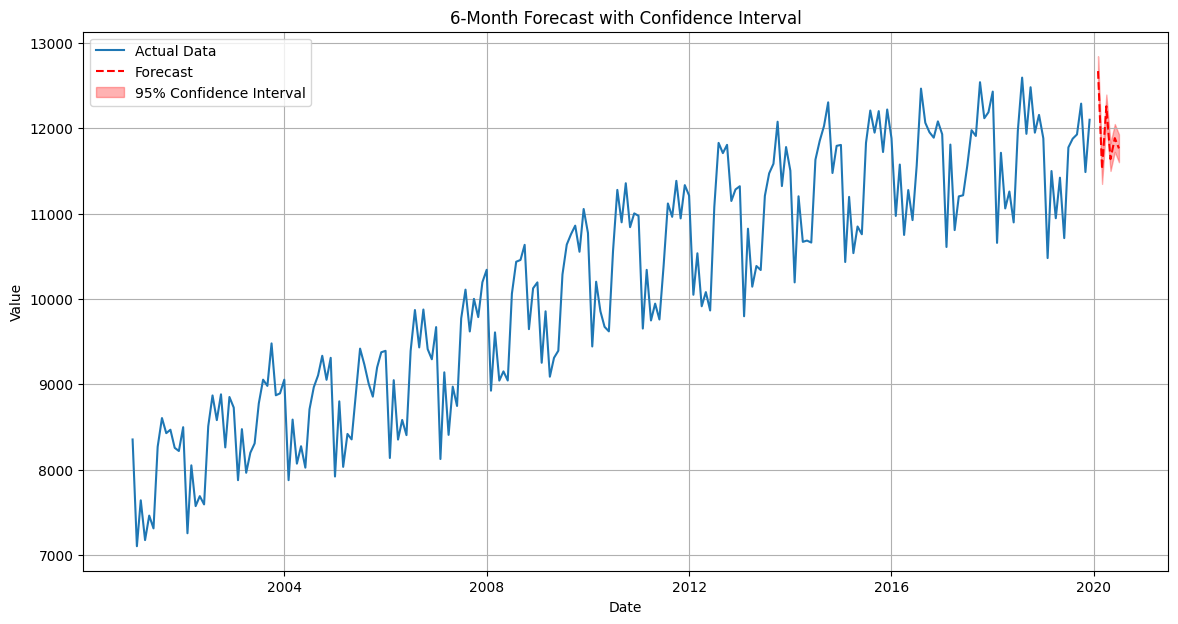

In [76]:
import statsmodels.api as sm

# Fit your model with the correct features
X = monthly_birth[features]
y = monthly_birth['value']
model = LinearRegression().fit(X, y)

# Forecasting setup
forecast_months = 6
t_forecast = np.arange(n + 1, n + forecast_months + 1)
forecast_dates = pd.date_range(start=monthly_birth.index[-1] + pd.DateOffset(months=1), periods=forecast_months, freq='M')
data_forecast = pd.DataFrame(index=forecast_dates)

# Generate Fourier terms for forecast data
for k in range(1, K + 1):
    data_forecast[f'sin_{k}'] = np.sin(2 * np.pi * k * t_forecast / 12)
    data_forecast[f'cos_{k}'] = np.cos(2 * np.pi * k * t_forecast / 12)

if 'time' in features:
    data_forecast['time'] = t_forecast

X_forecast = data_forecast[features]

# Predict future values
predictions = model.predict(X_forecast)
data_forecast['prediction'] = predictions

# Statsmodels for confidence intervals
X_sm = sm.add_constant(X)  # adding a constant for OLS
model_sm = sm.OLS(y, X_sm).fit()
X_forecast_sm = sm.add_constant(X_forecast)
predictions_ci = model_sm.get_prediction(X_forecast_sm).summary_frame(alpha=0.05)

# Plot the original data and predictions with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(monthly_birth.index, monthly_birth['value'], label='Actual Data')
plt.plot(data_forecast.index, data_forecast['prediction'], 'r--', label='Forecast')
plt.fill_between(data_forecast.index, predictions_ci['mean_ci_lower'], predictions_ci['mean_ci_upper'], color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('6-Month Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
